In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import InsectDatamodule
import numpy as np
import pandas as pd
import torchaudio
import torch
import IPython.display as ipd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [60]:
datamodule = InsectDatamodule(csv_paths=['../data/Cicadidae.csv', '../data/Orthoptera.csv'], batch_size=10)
train_dataloader = datamodule.train_dataloader()

metadata = train_dataloader.dataset.get_metadata()

In [61]:
# Set global parameters for axis labels and tick sizes
plt.rcParams['axes.labelsize'] = 18  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 12  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Adjust the size of the y-axis tick labels
plt.rcParams['axes.titlesize'] = 20  # Adjust the size of the title
# plt.rcParams['axes.titleweight'] = 'bold' # Make the title bold

Precision and recall

https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/

## Plotting the Visualization of the Transformation

In [62]:
def normalize(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def plot_transformation(path: str,
            index: int,
            n_fft: int, 
            top_db: int | None, 
            n_mels: int, 
            pad_length: int = 0, 
            show_audiosample: bool = False, 
            show_waveform: bool = False
            ):

    # loading the sample
    waveform, samplerate = train_dataloader.dataset.load_sample(path)

    # displaying the audio sample if true
    if show_audiosample:
        ipd.display(ipd.Audio(waveform.numpy()[0], rate=samplerate))


    # zero padding the waveform if needed
    if pad_length > 0:

        pad_samples = int(pad_length * samplerate)
        waveform = torch.nn.functional.pad(waveform, pad=(pad_samples, 0, 0, 0))


    # Displaying Waveform if true
    if show_waveform:

        time = np.arange(0, len(waveform[0])) / samplerate

        plt.plot(time, waveform[0, :])
        plt.title('Waveform')
        plt.xlabel('Time (s)')
        plt.show()

    # creating the mel spectrogram
    mel = torchaudio.transforms.MelSpectrogram(n_fft=n_fft, 
                                            hop_length=int(n_fft/2), 
                                            win_length=n_fft, 
                                            n_mels=n_mels
                                            )(waveform)

    # transforming the mel spectrogram with amplitude to db
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(mel)

    # normalizing the transformed mel spectrogram
    mel_db_norm = normalize(mel_db)

    # creating the spectrogram
    spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, 
                                            hop_length=int(n_fft/2), 
                                            win_length=n_fft
                                            )(waveform)

    # transforming the spectrogram with amplitude to db
    spec_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)

    # normalizing the transformed spectrogram
    spec_db_norm = normalize(spec_db)

    #setting up the plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # plotting subplots
    ax[0].imshow(spec_db_norm.numpy().squeeze(), origin='lower', aspect='auto')
    ax[0].set_title('Spectrogram')
    fig.colorbar(ax[0].imshow(spec_db_norm.numpy().squeeze(), origin='lower', aspect='auto'), ax=ax[0])

    ax[1].imshow(mel_db_norm.numpy().squeeze(), origin='lower', aspect='auto')
    ax[1].set_title('Mel spectrogram')
    fig.colorbar(ax[1].imshow(mel_db_norm.numpy().squeeze(), origin='lower', aspect='auto'), ax=ax[1])

    # creating a legend:
    text = f'sample_index: {index}, n_fft: {n_fft}, n_mels: {n_mels}, top_db: {top_db}'

    # displaying the plot
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # adjust the bottom margin
    # plt.text(0.02, 0.1, text, ha='left', va='top', transform=fig.transFigure)
    
    return fig

In [63]:
figure_path = "../LaTeX/figures/"                                    
# figure_path = None

# setting up the parameters
index=26
n_fft = 1024
n_mels = 64
top_db = None
pad_length = 0
show_audiosample = False
show_waveform = False

path = metadata['path'][index]

fig = plot_transformation(path=path,
        index=index,
        n_fft=n_fft, 
        top_db=top_db, 
        n_mels=n_mels, 
        pad_length=pad_length, 
        show_audiosample=show_audiosample, 
        show_waveform=show_waveform)

if figure_path is not None:
        fig.savefig(f'{figure_path}compare_spectrogram.pdf')
        plt.close(fig)


## Plotting  Visualizations for best Model

In [ ]:
path_best_model = '../logs/main_run/mel064_nblock4_lr0.001_ks5'

In [ ]:
def get_ytrue_yhat(model_path: str, data_set_selection: list = ["test"]):

    path = f'{model_path}/predictions.csv'
    data = pd.read_csv(path)

    filtered_data = data[data['data_set'].isin(data_set_selection)]

    y_true = filtered_data['class_ID']
    y_pred = filtered_data['class_ID_pred']

    return y_true, y_pred

In [ ]:
figure_path = "../LaTeX/figures/"
# figure_path = None


y_true, y_pred = get_ytrue_yhat(path_best_model)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, colorbar=False)

# Label the axes
ax.set_xlabel('Predicted ClassID')
ax.set_ylabel('True ClassID')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

im = ax.imshow(cm, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)

if figure_path is None:
    plt.show()
else:
    fig.savefig(f'{figure_path}confusion_matrix_best.pdf')
    plt.close(fig)


## Visualizing the Hyperparameter Tuning of the Model

In [69]:
table_path = None
# table_path = "../LaTeX/tables/"

eval_csv_path = "../logs/main_run/evaluation/eval_summary.csv"

# Loading the evaluation data
eval_data = pd.read_csv(eval_csv_path)
eval_data_selected = eval_data[['n_mels', 'n_res_blocks', 'learning_rate', 'kernel_size', 'num_trainable_params', 'trained_epochs', 'accuracy', 'f1']]
eval_data_selected.loc[:, 'n_mels'] = eval_data_selected['n_mels'].fillna(-1).astype(int)
eval_data_selected_arranged = eval_data_selected.sort_values(by='accuracy', ascending=False)

# Formatting the DataFrame
eval_data_selected_arranged['n_mels'] = eval_data_selected_arranged['n_mels'].apply(lambda x: f"{x:.0f}")
eval_data_selected_arranged['learning_rate'] = eval_data_selected_arranged['learning_rate'].apply(lambda x: f"{x:.3g}")
eval_data_selected_arranged['accuracy'] = eval_data_selected_arranged['accuracy'].apply(lambda x: f"{x:.3f}")
eval_data_selected_arranged['num_trainable_params'] = eval_data_selected_arranged['num_trainable_params'].apply(lambda x: f"{int(x):,}")

# Convert DataFrame to LaTeX table
latex_table = eval_data_selected_arranged.to_latex(
    index=False, 
    column_format="rrrrrrr"
)

# Manually replace the header row to make it bold
old_header = "n_mels & n_res_blocks & learning_rate & kernel_size & num_trainable_params & trained_epochs & accuracy \\\\"
new_header = "\\textbf{n\\_mels} & \\textbf{n\\_res\\_blocks} & \\textbf{learning\\_rate} & \\textbf{kernel\\_size}& \\textbf{trainable\\_params} & \\textbf{trained\\_epochs} & \\textbf{accuracy} \\\\"
latex_table = latex_table.replace(old_header, new_header)


# Saving the table
if table_path is None:
    print(latex_table)
else:
    with open(f'{table_path}hyperparameters_results.tex', 'w') as f:
        f.write(latex_table)

\begin{tabular}{rrrrrrr}
\toprule
n_mels & n_res_blocks & learning_rate & kernel_size & num_trainable_params & trained_epochs & accuracy & f1 \\
\midrule
64 & 4 & 0.001 & 5 & 832,912 & 1018 & 0.649 & 0.546000 \\
-1 & 2 & 0.001 & 5 & 50,256 & 640 & 0.608 & 0.422000 \\
64 & 3 & 0.001 & 5 & 207,376 & 505 & 0.608 & 0.471000 \\
-1 & 3 & 0.0001 & 3 & 78,224 & 897 & 0.581 & 0.496000 \\
-1 & 4 & 0.0001 & 3 & 310,544 & 891 & 0.568 & 0.480000 \\
-1 & 2 & 0.001 & 3 & 19,408 & 469 & 0.568 & 0.408000 \\
-1 & 3 & 0.0001 & 7 & 401,104 & 760 & 0.568 & 0.450000 \\
-1 & 4 & 0.0001 & 5 & 832,912 & 672 & 0.554 & 0.414000 \\
64 & 4 & 0.0001 & 5 & 832,912 & 371 & 0.554 & 0.446000 \\
64 & 3 & 0.001 & 7 & 401,104 & 350 & 0.541 & 0.395000 \\
64 & 3 & 0.0001 & 7 & 401,104 & 536 & 0.541 & 0.439000 \\
64 & 3 & 0.0001 & 3 & 78,224 & 1115 & 0.541 & 0.424000 \\
-1 & 2 & 0.0001 & 7 & 96,528 & 1198 & 0.541 & 0.429000 \\
-1 & 3 & 0.001 & 5 & 207,376 & 394 & 0.527 & 0.429000 \\
-1 & 3 & 0.001 & 3 & 78,224 & 456 & 0.500 

## Basil

In [71]:
eval_data_selected_arranged

,n_mels,n_res_blocks,learning_rate,kernel_size,num_trainable_params,trained_epochs,accuracy,f1
12,64,4,0.001,5,"832,912",1018,0.649,0.546
7,-1,2,0.001,5,"50,256",640,0.608,0.422
21,64,3,0.001,5,"207,376",505,0.608,0.471
27,-1,3,0.0001,3,"78,224",897,0.581,0.496
28,-1,4,0.0001,3,"310,544",891,0.568,0.480
5,-1,2,0.001,3,"19,408",469,0.568,0.408
8,-1,3,0.0001,7,"401,104",760,0.568,0.450
24,-1,4,0.0001,5,"832,912",672,0.554,0.414
11,64,4,0.0001,5,"832,912",371,0.554,0.446
0,64,3,0.001,7,"401,104",350,0.541,0.395


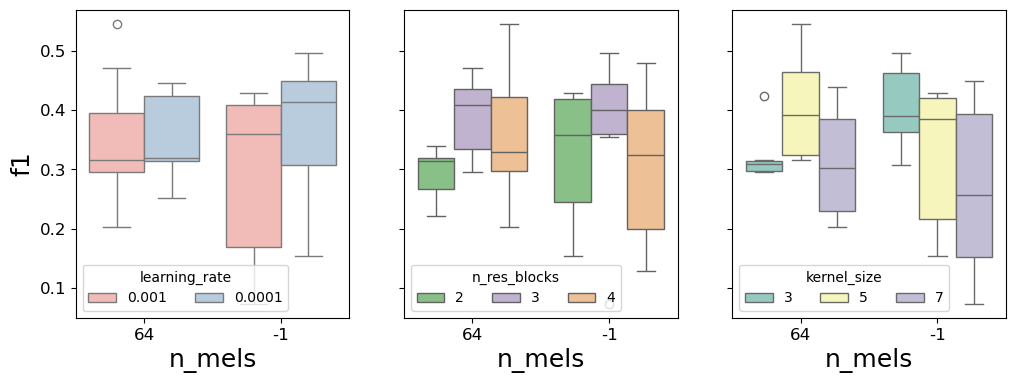

In [72]:
fix, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

for i, (hp, cmap) in enumerate(zip(
        ['learning_rate', 'n_res_blocks', 'kernel_size'],
        ['Pastel1', 'Accent', 'Set3'])):
    ax = axes[i]
    sns.boxplot(
        data=eval_data_selected_arranged,
        x='n_mels',
        y='accuracy',
        palette=cmap,
        hue=hp,
        ax=ax)

    sns.move_legend(ax, 'lower left', ncols=3)

    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])


<Axes: xlabel='num_trainable_params', ylabel='f1'>

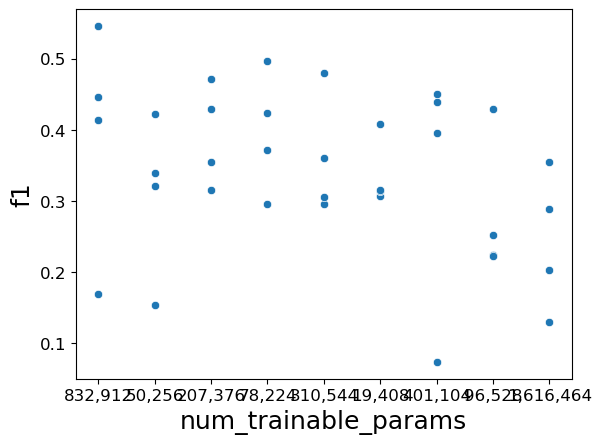

In [73]:
# Larger models do not necessarily have better accuracy.
fig, ax = plt.subplots()

sns.scatterplot(
    data=eval_data_selected_arranged,
    x='num_trainable_params',
    y='accuracy',
    ax=ax
)

## creating a table showing the label and names of the insects

In [ ]:
# table_path = None
table_path = "../LaTeX/tables/"

unique_class_id = metadata[['class_id', 'species']].drop_duplicates(subset=['class_id']).sort_values(by='class_id')

# Split data into two parts
half = len(unique_class_id) // 2 + len(unique_class_id) % 2
first_half = unique_class_id.iloc[:half].reset_index(drop=True)
second_half = unique_class_id.iloc[half:].reset_index(drop=True)

# Concatenate first half and second half side by side
concatenated = pd.concat([first_half, second_half], axis=1)

# Adjust column names for LaTeX output
concatenated.columns = ['ClassID', 'Species', 'ClassID', 'Species']

# Convert to LaTeX
latex_table = concatenated.to_latex(
    index=False, 
    column_format="rlrl",
    header=True
)


# Saving the table
if table_path is None:
    print(latex_table)
else:
    with open(f'{table_path}ClassID_legend.tex', 'w') as f:
        f.write(latex_table)

## Model visualization

In [ ]:
from model import ResNet

In [ ]:
model = ResNet.load_from_checkpoint('../logs/default/mel064_nblock4_lr0.01/checkpoints/best.ckpt')

In [ ]:
model

In [23]:
n=1


def Hstar(n):
    n_max_pool = 3
    H = 100

    return H // (3 ** ((n + 1) // 2))

In [24]:
for n in range(1, 10):
    print(f"n={n}: {Hstar(n)}")

n=1: 33
n=2: 33
n=3: 11
n=4: 11
n=5: 3
n=6: 3
n=7: 1
n=8: 1
n=9: 0
